In [96]:
#reference by : https://www.kaggle.com/code/flaviocavalcante/e-commerce-data-analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import plotly.graph_objects as go
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl', offline=True)

import warnings
warnings.filterwarnings( 'ignore' )
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (20,10)


In [54]:
def highlight_cols(val):
    if val < 100 :
        color = 'lightblue'
    else:
        color = 'orange'
    return 'color: %s' % color

In [55]:
sales_target = pd.read_csv("SalesTarget.csv")
order_details = pd.read_csv("Details.csv")
list_orders = pd.read_csv("Orders.csv")

In [56]:
orders = list_orders.merge(order_details, on='Order ID')
orders.head()

,Order ID,Order Date,CustomerName,State,City,Amount,Profit,Quantity,Category,Sub-Category
0,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad,1275.0,-1148.0,7,Furniture,Bookcases
1,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad,66.0,-12.0,5,Clothing,Stole
2,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad,8.0,-2.0,3,Clothing,Hankerchief
3,B-25601,01-04-2018,Bharat,Gujarat,Ahmedabad,80.0,-56.0,4,Electronics,Electronic Games
4,B-25602,01-04-2018,Pearl,Maharashtra,Pune,168.0,-111.0,2,Electronics,Phones


In [57]:
# df orders
new_cols = {}
for col in orders.columns:
    new_col = col.replace(" ", "_").replace("-","_").lower()
    new_cols[col] = new_col
orders = orders.rename(columns = new_cols)

# extract month and year
orders['month'] = orders['order_date'].apply(lambda x: x.split("-")[1])
orders['year'] = orders['order_date'].apply(lambda x: x.split("-")[2])
orders['month'] = orders['month'].astype(int)
orders['year'] = orders['year'].astype(int)
# parse to datetime
orders['order_date'] = pd.to_datetime(orders['order_date'],dayfirst = True )
# orders['margin'] = round(orders['amount'] / orders['profit'])

# df sales target
cols_target = {'Month of Order Date':'month_order_date', 'Category':'category'}
sales_target.rename(columns = cols_target, inplace =True)
sales_target['month'] = sales_target['month_order_date'].apply(lambda x: x.split("-")[0])
sales_target['year'] = sales_target['month_order_date'].apply(lambda x: x.split("-")[1])
sales_target['year'] = sales_target['year'].astype(int)
sales_target['year'] = sales_target['year'] + 2000
month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
sales_target['month'] = sales_target.month.map(month_map)
sales_target.head()

,month_order_date,category,Target,month,year
0,Apr-18,Furniture,10400.0,4,2018
1,May-18,Furniture,10500.0,5,2018
2,Jun-18,Furniture,10600.0,6,2018
3,Jul-18,Furniture,10800.0,7,2018
4,Aug-18,Furniture,10900.0,8,2018


**EDA**

In [58]:
order_agrup  = orders.groupby(['customername','state','city','category', 'month', 'year'])[['amount','profit', 'quantity']]\
                     .sum()\
                     .reset_index()

order_agrup.head()

,customername,state,city,category,month,year,amount,profit,quantity
0,Aakanksha,Madhya Pradesh,Indore,Clothing,7,2018,33.0,-12.0,7
1,Aakanksha,Madhya Pradesh,Indore,Furniture,7,2018,41.0,-6.0,1
2,Aarushi,Tamil Nadu,Chennai,Clothing,2,2019,61.0,8.0,4
3,Aarushi,Tamil Nadu,Chennai,Clothing,3,2019,833.0,10.0,15
4,Aarushi,Tamil Nadu,Chennai,Clothing,4,2018,257.0,23.0,5


In [68]:
list_orders.info()
order_details.info()
sales_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Order ID      500 non-null    object
 1   Order Date    500 non-null    object
 2   CustomerName  500 non-null    object
 3   State         500 non-null    object
 4   City          500 non-null    object
dtypes: object(5)
memory usage: 22.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order ID      1500 non-null   object 
 1   Amount        1500 non-null   float64
 2   Profit        1500 non-null   float64
 3   Quantity      1500 non-null   int64  
 4   Category      1500 non-null   object 
 5   Sub-Category  1500 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 70.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex

**Average amount spent on each Categories**

In [69]:
print("Furniture: ",order_details[order_details["Category"] == 'Furniture']['Amount'].mean())
print("Electronics: ",order_details[order_details["Category"] == 'Electronics']['Amount'].mean())
print("Clothing: ",order_details[order_details["Category"] == 'Clothing']['Amount'].mean())


Furniture:  523.3786008230453
Electronics:  536.5811688311688
Clothing:  146.5268703898841


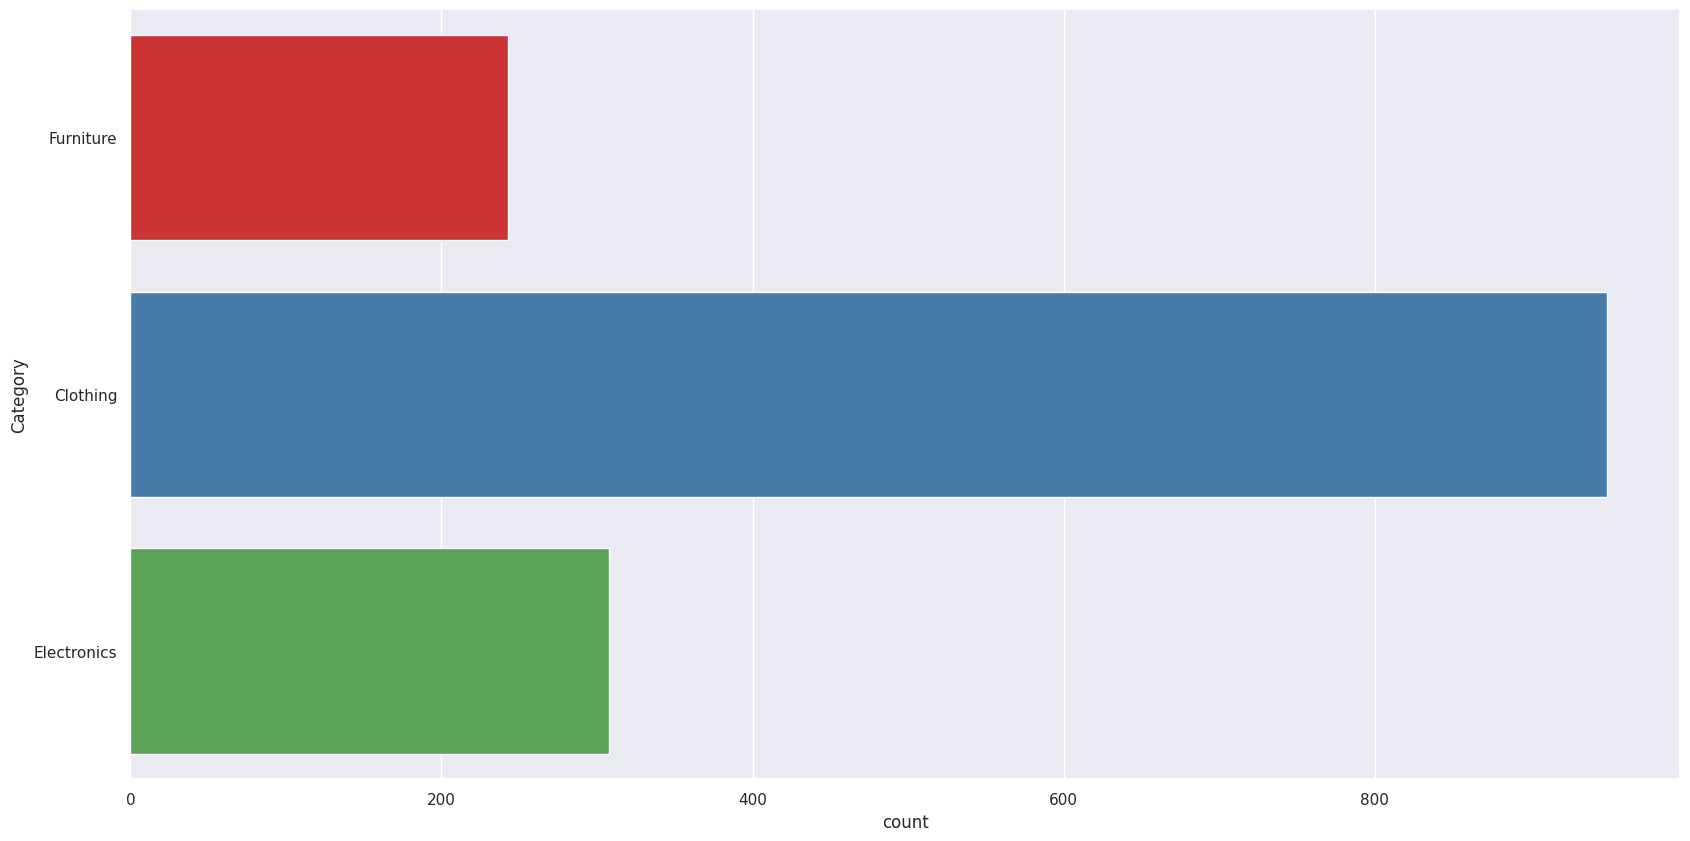

In [70]:
# Countplot w.r.t 'Categories'
ax = sns.countplot(y='Category',data=order_details, palette='Set1')
# for p in ax.patches:
#         ax.annotate('%{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))

In [59]:
def atp_cal(col, data: pd.DataFrame,top = 30):

    data = data.groupby([col])[['amount', 'quantity']].sum().reset_index()
    data['avg_ticket_price'] = round(data['amount'] / data['quantity'],2)
    data.sort_values(by='avg_ticket_price', ascending = False, inplace =True)
    data = data.head(top)

    return data


Average Price

**atp = total amount / total quantity**

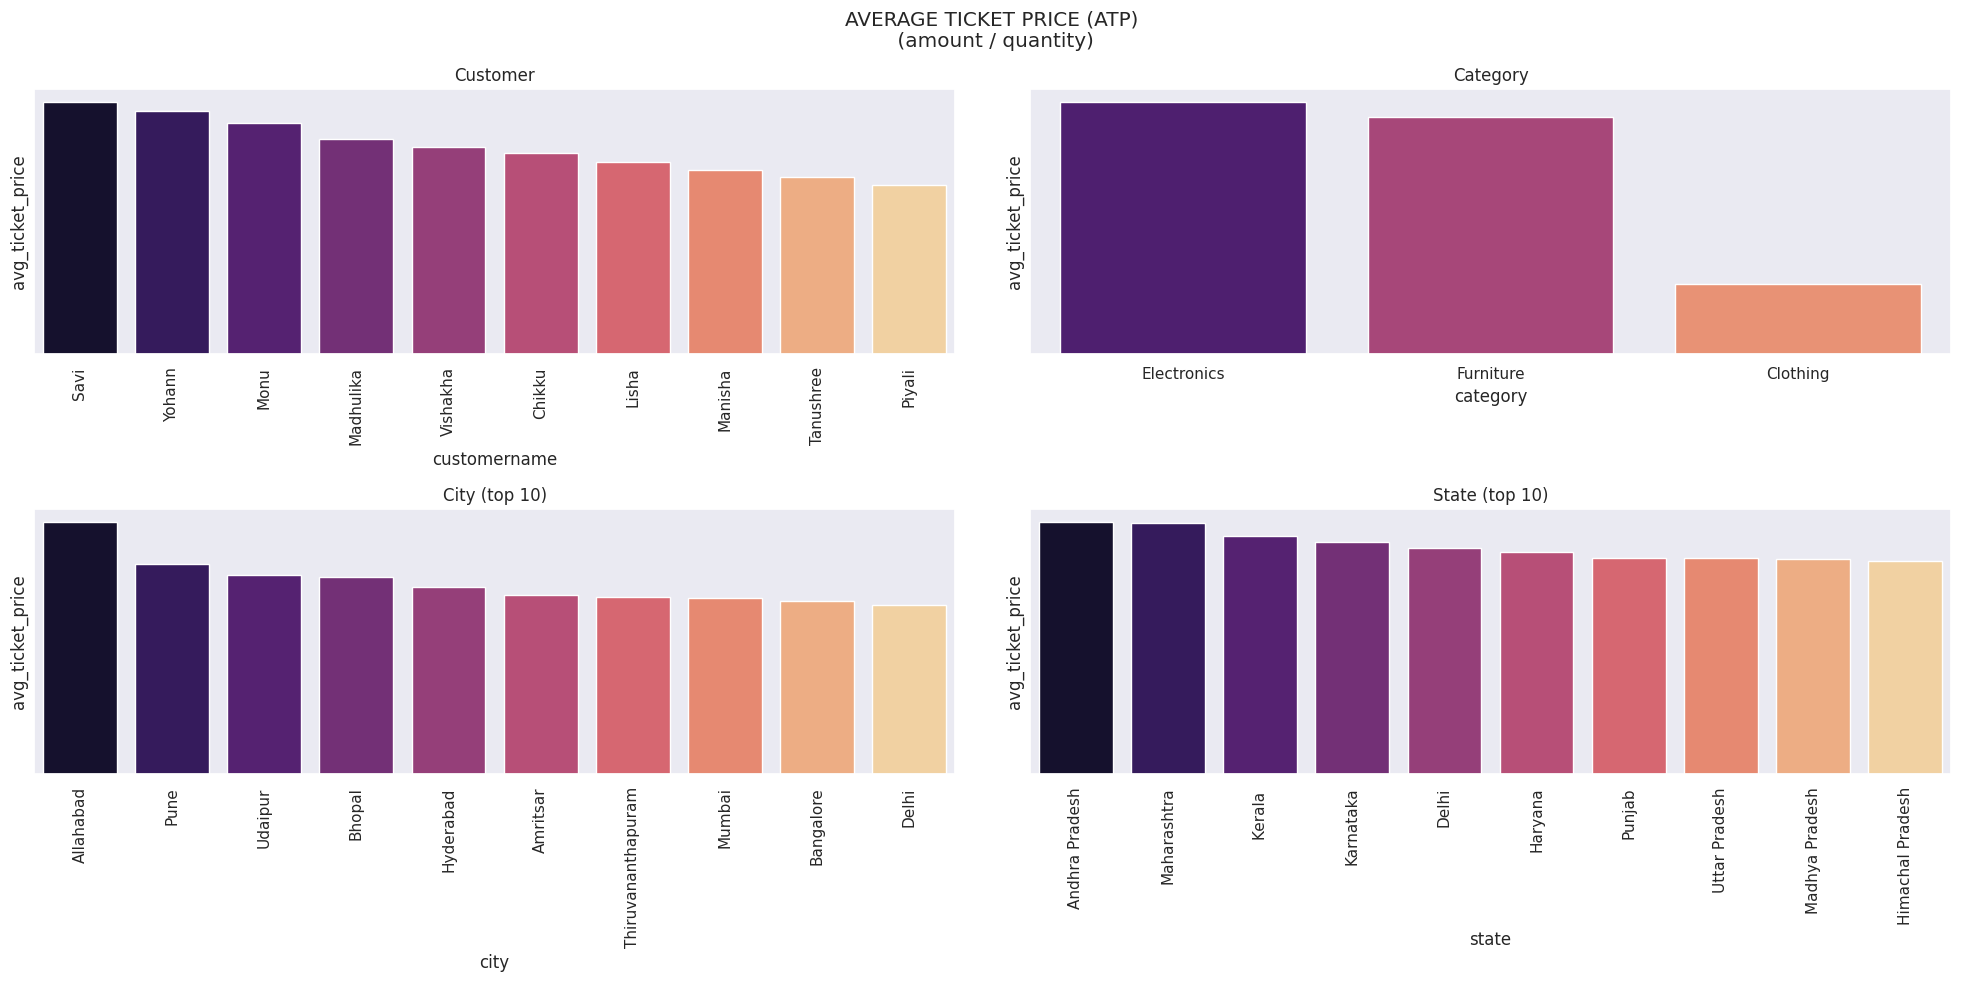

In [60]:
plt.suptitle("AVERAGE TICKET PRICE (ATP)\n (amount / quantity)")


# customer
atp = atp_cal('customername',order_agrup)
avg_all = atp['amount'].sum() / atp['quantity'].sum()
atp_10 = atp.head(10)

plt.subplot(2,2,1)
c_1 = sns.barplot(x = atp_10.customername, y =atp_10.avg_ticket_price, palette='magma');
# c_1.axhline(avg_all)
plt.title("Customer");
plt.tight_layout();
plt.xticks(rotation=90);
#get_label(c_1);
c_1.set(yticks=[]);


# Category
atp_category = atp_cal('category',order_agrup)
plt.subplot(2,2,2)
c_2 = sns.barplot(x = atp_category.category, y =atp_category.avg_ticket_price, palette='magma');
plt.title("Category");
plt.tight_layout();
#get_label(c_2)
c_2.set(yticks=[]);

# City
atp_city = atp_cal('city',order_agrup, 10)
atp_city = atp_city.head(10)
plt.subplot(2,2,3)
c_3 = sns.barplot(x = atp_city.city, y =atp_city.avg_ticket_price, palette='magma');
plt.title("City (top 10)");
plt.tight_layout();
plt.xticks(rotation=90);
#get_label(c_3)
c_3.set(yticks=[]);

# State
atp_state = atp_cal('state',order_agrup, 10)
atp_state = atp_state.head(10)
plt.subplot(2,2,4)
c_4 = sns.barplot(x = atp_state.state, y =atp_state.avg_ticket_price, palette='magma');
plt.title("State (top 10)");
plt.tight_layout();
plt.xticks(rotation=90);
#get_label(c_4)
c_4.set(yticks=[]);

In [61]:
orders['avg_ticket_price'] = round(orders['amount'] / orders['quantity'],2)

In [62]:
orders = orders.sort_values(by=['year','month'], ascending = False)
orders


,order_id,order_date,customername,state,city,amount,profit,quantity,category,sub_category,month,year,avg_ticket_price
1295,B-26043,2019-03-01,Amit,Sikkim,Gangtok,185.0,48.0,4,Clothing,Stole,3,2019,46.25
1296,B-26043,2019-03-01,Amit,Sikkim,Gangtok,62.0,28.0,5,Clothing,Hankerchief,3,2019,12.40
1297,B-26043,2019-03-01,Amit,Sikkim,Gangtok,79.0,5.0,6,Clothing,Hankerchief,3,2019,13.17
1298,B-26043,2019-03-01,Amit,Sikkim,Gangtok,30.0,12.0,3,Clothing,Skirt,3,2019,10.00
1299,B-26043,2019-03-01,Amit,Sikkim,Gangtok,122.0,50.0,7,Clothing,Stole,3,2019,17.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,B-25643,2018-04-29,Kirti,Jammu and Kashmir,Kashmir,50.0,-44.0,2,Clothing,Hankerchief,4,2018,25.00
97,B-25643,2018-04-29,Kirti,Jammu and Kashmir,Kashmir,37.0,-23.0,4,Clothing,Shirt,4,2018,9.25
98,B-25643,2018-04-29,Kirti,Jammu and Kashmir,Kashmir,263.0,-63.0,2,Electronics,Electronic Games,4,2018,131.50
99,B-25643,2018-04-29,Kirti,Jammu and Kashmir,Kashmir,36.0,-7.0,1,Electronics,Electronic Games,4,2018,36.00


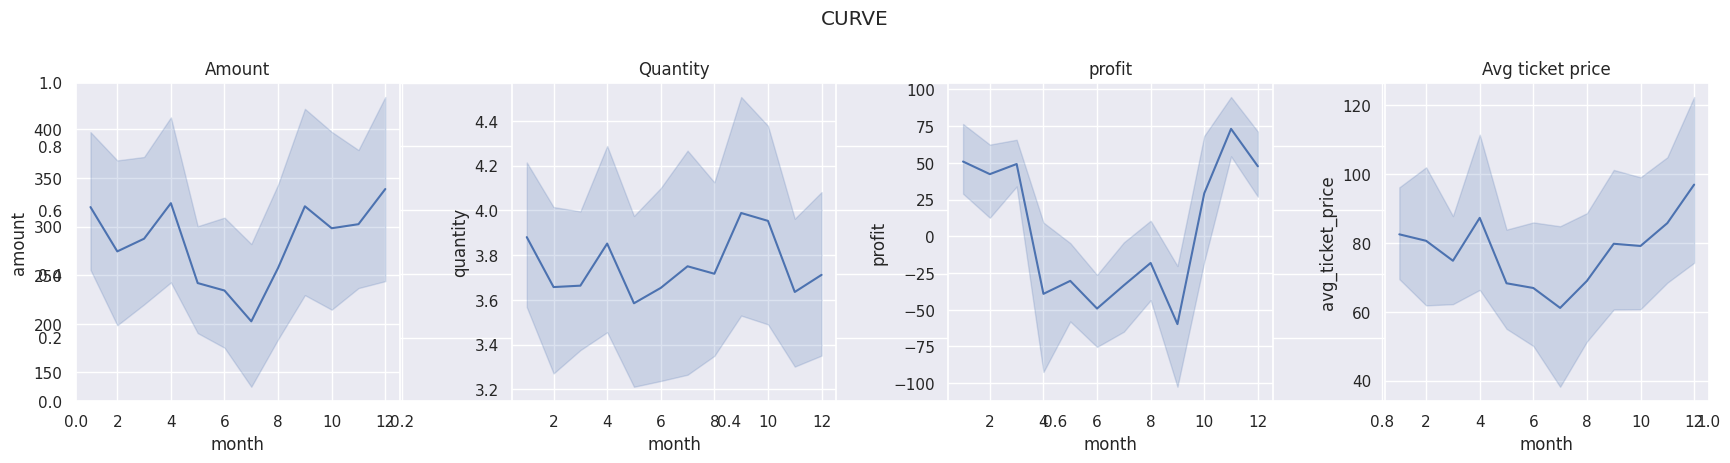

In [63]:
plt.subplots(figsize=(18, 5))
plt.subplot(141)
sns.lineplot(x=orders.month, y = orders.amount);
plt.title("Amount");
plt.subplot(142)
sns.lineplot(x=orders.month, y = orders.quantity);
plt.title("Quantity");
plt.subplot(143)
sns.lineplot(x=orders.month, y = orders.profit);
plt.title("profit");
plt.subplot(144)
sns.lineplot(x=orders.month, y = orders.avg_ticket_price);
plt.title("Avg ticket price");
plt.suptitle("CURVE");
plt.tight_layout();

**Profits**

In [64]:
profit = orders.groupby("month")[['profit']].sum().reset_index()
profit['dif'] = profit['profit'] - profit['profit'].shift(1)
profit.loc[0, 'dif'] = 0

month_map = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
profit['month'] = profit.month.map(month_map)

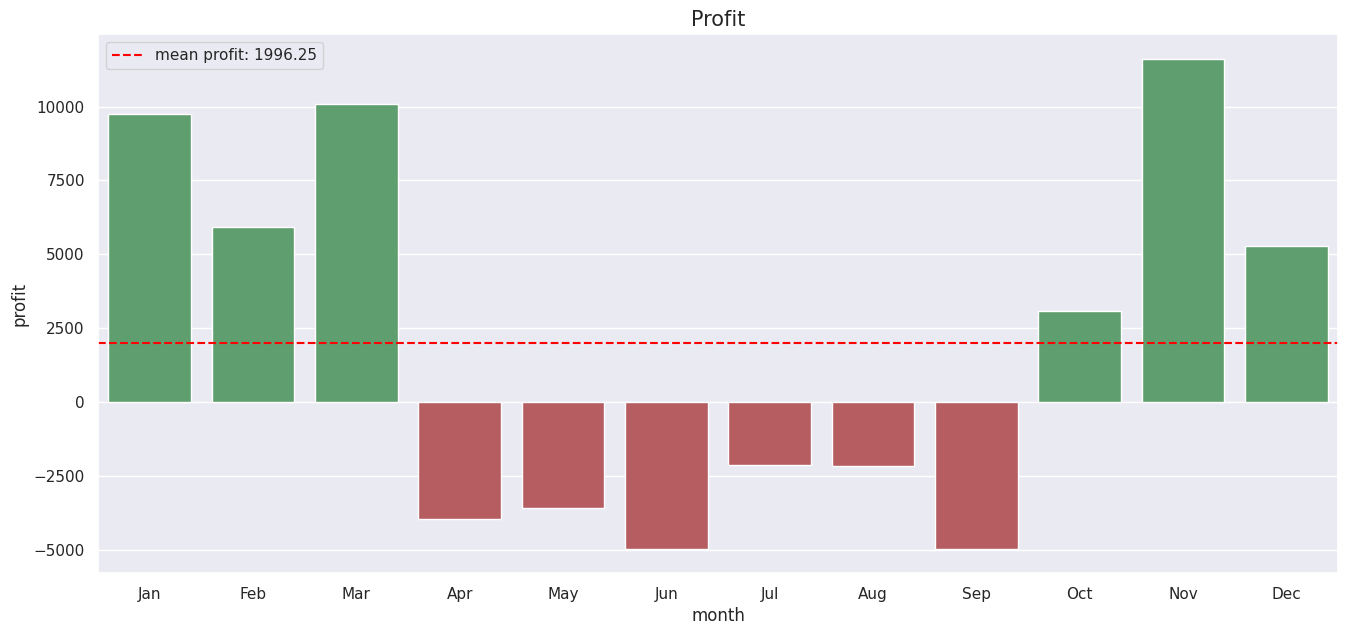

In [65]:
mean = profit['profit'].mean()

color = ['g' if c >= 0 else 'r' for c in profit['profit']]

plt.subplots(figsize=(16, 7))
g = sns.barplot(x='month', y ='profit', data=profit, palette = color);
g.axhline(mean, color ='red', linestyle= '--', label = f'mean profit: {mean}')
plt.title('Profit', size = 15);
#get_label(g);
plt.legend();

# for i in range(len(list(profit['dif']))):
#     plt.text(i, dfis[i]//2, dfis[i], ha='center', va = 'center_baseline', bbox=dict(facecolor='red', alpha=0.5))




**Target**

In [52]:
orders_target = orders.groupby(['month','year', 'category'])[['amount']].sum().reset_index()
orders_target.set_index(['year','month', 'category'], inplace = True)
# sales_target.set_index(['year','month', 'category'],inplace = True,)
orders_target['target'] = sales_target[['Target']]
orders_target = orders_target.reset_index()
orders_target.head(10)



,year,month,category,amount,target
0,2019,1,Clothing,13466.0,16000.0
1,2019,1,Electronics,26716.0,16000.0
2,2019,1,Furniture,21257.0,11500.0
3,2019,2,Clothing,9569.0,16000.0
4,2019,2,Electronics,12593.0,16000.0
5,2019,2,Furniture,16262.0,11600.0
6,2019,3,Clothing,21418.0,16000.0
7,2019,3,Electronics,20860.0,16000.0
8,2019,3,Furniture,16659.0,11800.0
9,2018,4,Clothing,13478.0,12000.0


In [66]:
orders_target['variation'] = round((orders_target['amount'] / orders_target['target']) *100)
orders_target.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['variation']])

,year,month,category,amount,target,variation
0,2019,1,Clothing,13466.000000,16000.000000,84.000000
1,2019,1,Electronics,26716.000000,16000.000000,167.000000
2,2019,1,Furniture,21257.000000,11500.000000,185.000000
3,2019,2,Clothing,9569.000000,16000.000000,60.000000
4,2019,2,Electronics,12593.000000,16000.000000,79.000000
5,2019,2,Furniture,16262.000000,11600.000000,140.000000
6,2019,3,Clothing,21418.000000,16000.000000,134.000000
7,2019,3,Electronics,20860.000000,16000.000000,130.000000
8,2019,3,Furniture,16659.000000,11800.000000,141.000000
9,2018,4,Clothing,13478.000000,12000.000000,112.000000


Total amount spent by each customer.

In [83]:
new_df = pd.merge(order_details, list_orders, on='Order ID', how='left')

In [73]:
grouper = new_df.groupby(['CustomerName','State'])['Amount'].sum().reset_index()
grouper

,CustomerName,State,Amount
0,Aakanksha,Madhya Pradesh,74.0
1,Aarushi,Tamil Nadu,4701.0
2,Aashna,Uttar Pradesh,1931.0
3,Aastha,Himachal Pradesh,3276.0
4,Aayush,Uttar Pradesh,556.0
...,...,...,...
394,Yaanvi,Madhya Pradesh,9177.0
395,Yash,Maharashtra,791.0
396,Yogesh,Bihar,2834.0
397,Yogesh,Madhya Pradesh,2587.0


Total amount spent by each customer

In [74]:
grouper = new_df.groupby(['CustomerName','State'])['Amount'].sum().reset_index()
grouper

,CustomerName,State,Amount
0,Aakanksha,Madhya Pradesh,74.0
1,Aarushi,Tamil Nadu,4701.0
2,Aashna,Uttar Pradesh,1931.0
3,Aastha,Himachal Pradesh,3276.0
4,Aayush,Uttar Pradesh,556.0
...,...,...,...
394,Yaanvi,Madhya Pradesh,9177.0
395,Yash,Maharashtra,791.0
396,Yogesh,Bihar,2834.0
397,Yogesh,Madhya Pradesh,2587.0


Customers who have spent the most amount

In [75]:
# Sorting by the top 10
val = grouper.sort_values(by='Amount', ascending=False).head(10)
val

,CustomerName,State,Amount
394,Yaanvi,Madhya Pradesh,9177.0
357,Surabhi,Maharashtra,6611.0
340,Soumya,Maharashtra,6339.0
128,Harshal,Delhi,6026.0
237,Pooja,Uttar Pradesh,5809.0
287,Sarita,Maharashtra,5449.0
293,Seema,Uttar Pradesh,5228.0
227,Parth,Maharashtra,5161.0
89,Bhishm,Maharashtra,4907.0
391,Vishakha,Maharashtra,4836.0


Plot on customers who have spent the most amount

In [77]:
import plotly.express as px
fig = px.bar(val, x='CustomerName', y='Amount', color='CustomerName', barmode='relative', hover_data=['State'])
fig.show()

In [78]:
px.histogram(new_df,x='State',color='Category', text_auto=True)


Top 10 states with most number of purchased items/ orders

In [81]:
# Top 10 states with most number of purchased items/ orders
category_grouper = new_df.groupby(['State'])['Category'].count().reset_index()
top_10_states = category_grouper.sort_values(by='Category', ascending=False).head(10)

In [82]:
fig2 = px.bar(top_10_states, x='State', y='Category', color='State', barmode='relative', hover_data=['State'])
fig2.show()

Sales Analysis

In [85]:
orders = order_details.merge(list_orders[['Order ID','Order Date']], left_on='Order ID',right_on='Order ID', how='inner')
orders.head()

,Order ID,Amount,Profit,Quantity,Category,Sub-Category,Order Date
0,B-25601,1275.0,-1148.0,7,Furniture,Bookcases,01-04-2018
1,B-25601,66.0,-12.0,5,Clothing,Stole,01-04-2018
2,B-25601,8.0,-2.0,3,Clothing,Hankerchief,01-04-2018
3,B-25601,80.0,-56.0,4,Electronics,Electronic Games,01-04-2018
4,B-25602,168.0,-111.0,2,Electronics,Phones,01-04-2018


Creating a copy of new dataset¶

In [88]:
orders_copy = copy.deepcopy(orders)


Creating row with month and year of order to get know month good flow¶

In [90]:
orders_copy['Date'] = orders_copy['Order Date'].apply(lambda x:x[6::]+'-'+x[3:5])

Creating dataset with information about monthly profit by goods' sub-categories

In [91]:
orderssub = orders_copy.groupby(['Sub-Category', 'Date']).Profit.sum().unstack().reset_index()
orderssub.head()

Date,Sub-Category,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03
0,Accessories,-55.0,-66.0,-89.0,30.0,-29.0,265.0,-604.0,466.0,320.0,997.0,1401.0,923.0
1,Bookcases,-1014.0,-75.0,NaN,-33.0,986.0,612.0,-1730.0,1704.0,292.0,2458.0,1101.0,587.0
2,Chairs,-444.0,-555.0,-426.0,-176.0,-193.0,-991.0,418.0,1328.0,232.0,665.0,258.0,461.0
3,Electronic Games,-326.0,-1481.0,-1220.0,-80.0,-372.0,-471.0,399.0,847.0,723.0,511.0,212.0,22.0
4,Furnishings,-103.0,-98.0,16.0,-248.0,-350.0,-115.0,110.0,640.0,112.0,161.0,382.0,337.0


In [92]:
orderssub['Profit Summary'] = orderssub.iloc[:,1:14].sum(axis=1)

In [93]:
orderssub

Date,Sub-Category,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,Profit Summary
0,Accessories,-55.0,-66.0,-89.0,30.0,-29.0,265.0,-604.0,466.0,320.0,997.0,1401.0,923.0,3559.0
1,Bookcases,-1014.0,-75.0,NaN,-33.0,986.0,612.0,-1730.0,1704.0,292.0,2458.0,1101.0,587.0,4888.0
2,Chairs,-444.0,-555.0,-426.0,-176.0,-193.0,-991.0,418.0,1328.0,232.0,665.0,258.0,461.0,577.0
3,Electronic Games,-326.0,-1481.0,-1220.0,-80.0,-372.0,-471.0,399.0,847.0,723.0,511.0,212.0,22.0,-1236.0
4,Furnishings,-103.0,-98.0,16.0,-248.0,-350.0,-115.0,110.0,640.0,112.0,161.0,382.0,337.0,844.0
5,Hankerchief,-137.0,-25.0,-290.0,-75.0,-1.0,-33.0,374.0,608.0,340.0,386.0,381.0,570.0,2098.0
6,Kurti,-47.0,NaN,-92.0,NaN,-119.0,-95.0,0.0,200.0,177.0,65.0,2.0,90.0,181.0
7,Leggings,43.0,-19.0,-13.0,-56.0,-42.0,-10.0,27.0,73.0,41.0,26.0,33.0,157.0,260.0
8,Phones,327.0,-608.0,-163.0,-1847.0,-205.0,-62.0,1201.0,748.0,1628.0,901.0,-352.0,639.0,2207.0
9,Printers,-297.0,-368.0,-606.0,264.0,-942.0,-642.0,1265.0,1877.0,525.0,2376.0,666.0,1846.0,5964.0


Get know what sub-categories cause losses. These is Electronic games and Tables¶

array(['Electronic Games', 'Tables'], dtype=object)

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
